<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Visualization of Inspiration Astronaut Biomarkers After 3 Days in Space

## Background
We are acting as the first data scientist on the Inspiration-Health project. Our first major task is to build a reproducible pipeline to clean, transform, and visualize astronaut biomarker data from the SpaceX Inspiration4 mission.
Instead of building predictive models, our focus is on identifying and visualizing significant deviations from baseline values to help communicate health changes during and after spaceflight.


## Data
We are working with astronaut biospecimen data from the SpaceX Inspiration4 Mission (NASA OSD-575).
The cleaned files in `cleaned_data/` include the Comprehensive Metabolic Panel (CMP), Cardiovascular Multiplex Panel, and Immune Multiplex Panel.

Each dataset is organized in long format, where each row corresponds to a single measurement for a given astronaut at a given timepoint.
Key columns include:

Each dataset is organized in long format, where each row corresponds to a single measurement for a given astronaut at a given timepoint.
Key columns include:

- analyte: the biomarker name (for example, glucose, creatinine, sodium, albumin)
- value: measured biomarker value
- range_min, range_max: clinical reference ranges for each analyte. Depending on the analyte, this is either the minimum/maximum detectable or the accepted healthy reference range
- units: measurement units (mg/dL, U/L, etc.)
- test_type: the panel type (CMP, cardiovascular multiplex, immune multiplex)
- subject_id: astronaut ID (C001–C004)
- sex: M or F
- timepoint: collection time relative to flight (L-92, L-44, L-3 pre-flight; R+1, R+45, R+82 post-flight)

These features allow us to:

- Track biomarker trajectories across mission phases
- Compare astronaut values to a baseline (pre-flight average)
- Identify deviations outside clinical reference ranges
- Visualize both individual astronaut responses and group trends

## Approach
We built a pipeline that follows these steps:

1. Load data
   Merge metadata and biomarker tables.

2. Clean data
   Handle missing values, outliers, and consistency issues.

3. Feature engineering for visualization
   Compute a baseline mean for each analyte (average of L-92, L-44, L-3).
   Calculate delta = value – baseline at each post-flight timepoint.
   Flag analytes with statistically or clinically notable deviations.

4. Visualization and App
   Create line plots of biomarker trajectories across timepoints.
   Highlight analytes with the largest relative changes.

### Preprocessing the data

The data files were preprocessed using `preprocess.py`.

This script automates the handling of astronaut health data stored in CSV files. It reads the transformed data from the `data` directory, extracts astronaut identifiers and timepoints, checks for missing or duplicate values, and saves cleaned datasets in both combined and astronaut-specific formats.

#### What the script does
1. Reads all CSV files in the specified input directory (`data` by default).
2. Splits the `Sample Name` column (for example, `C001_serum_L-3`) into two parts:
   - astronautID (e.g., C001)
   - timepoint (e.g., L-3)
3. Performs quality checks:
   - Reports any missing values per column
   - Reports duplicate rows if they exist
4. Saves outputs:
   - `<filename>_all_astronauts.csv` as the combined file with astronaut and timepoint columns added
   - `<filename>_<astronautID>.csv` as per-astronaut subsets for easier analysis

#### Expected input format
- Each CSV file must contain a column called `Sample Name`
- The expected naming convention in `Sample Name` is `astronautID_sampletype_timepoint`, for example `C001_serum_L-3`


<details>
<summary>Show preprocessing script embedded in preprocessing.py</summary>

```python
import os
import pandas as pd
from pathlib import Path

def process_files(input_dir="cleaned_data"):

    # Ensure directory exists
    input_path = Path(input_dir)
    if not input_path.exists():
        print(f"Directory {input_dir} not found.")
        return

    # Get all CSV files
    csv_files = [f for f in input_path.iterdir() if f.suffix == ".csv"]
    if not csv_files:
        print("No CSV files found in", input_dir)
        return

    for filepath in csv_files:
        filename = filepath.stem  # file name without extension
        print(f"\nProcessing {filepath.name}...")

        # Read CSV
        df = pd.read_csv(filepath)

        # --- Step 1: Split "Sample Name" ---
        if "Sample Name" not in df.columns:
            print(f" Skipping {filepath.name} (no 'Sample Name' column).")
            continue

        split_cols = df["Sample Name"].str.split("_", expand=True)

        # Expected format: C001_serum_L-3 → astronautID=C001, serum (ignored), timepoint=L-3
        if split_cols.shape[1] >= 3:
            df["astronautID"] = split_cols[0]
            df["timepoint"] = split_cols[2]
        else:
            print(f"Unexpected 'Sample Name' format in {filepath.name}")
            continue

        # --- Step 2: Check for missing values ---
        missing = df.isnull().sum()
        if missing.any():
            print("Missing values found:\n", missing[missing > 0])

        # --- Step 3: Check for duplicates ---
        duplicates = df.duplicated().sum()
        if duplicates > 0:
            print(f"Found {duplicates} duplicated rows")

        # --- Step 4: Save combined file ---
        all_astronauts_file = filepath.parent / f"{filename}_all_astronauts.csv"
        df.to_csv(all_astronauts_file, index=False)
        print(f"saved {all_astronauts_file.name}")

        # --- Step 5: Save per astronaut ---
        for astro_id, sub_df in df.groupby("astronautID"):
            out_file = filepath.parent / f"{filename}_{astro_id}.csv"
            sub_df.to_csv(out_file, index=False)
            print(f"Saved {out_file.name}")

if __name__ == "__main__":
    process_files("cleaned_data")
```

## Handling Missing Values

While cleaning the metabolic panel data we found a few gaps. Here is how we handled them:

- Total bilirubin (1 missing): filled with the median since the distribution is skewed
- BUN/creatinine ratio (22 missing): filled with the median for the same reason
- BUN/creatinine ratio min and max (1 missing each): filled with the median, safe for small gaps
- eGFR African American and non-African American (28 missing each): both columns dropped since all values were missing

### Why?
This approach keeps the data consistent while avoiding distortions from skewed lab values or empty columns.

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# load data from metabolic panel csv
df = pd.read_csv('cleaned_data/LSDS-8_Comprehensive_Metabolic_Panel_CMP_TRANSFORMED.csv')

# check for missing values
missing = df.isnull().sum()
missing = missing[missing > 0]
missing

# Treating Missing Values by Imputing or Dropping

# bilirubin values can be skewed, so median is more robust than mean
df["total_bilirubin_value_milligram_per_deciliter"] = df["total_bilirubin_value_milligram_per_deciliter"].fillna(
    df["total_bilirubin_value_milligram_per_deciliter"].median()
)

# do we drop this? 22/28 are missing → impute with median for now
df["bun_to_creatinine_ratio_value"] = df["bun_to_creatinine_ratio_value"].fillna(
    df["bun_to_creatinine_ratio_value"].median()
)

# values can be skewed, so median is more robust
df["bun_to_creatinine_ratio_range_min"] = df["bun_to_creatinine_ratio_range_min"].fillna(
    df["bun_to_creatinine_ratio_range_min"].median()
)
df["bun_to_creatinine_ratio_range_max"] = df["bun_to_creatinine_ratio_range_max"].fillna(
    df["bun_to_creatinine_ratio_range_max"].median()
)

# drop empty columns
df = df.drop(
    columns=[
        "egfr_african_american_range_max_milliliter_per_minute_per_1.73_meter_squared",
        "egfr_non_african_american_range_max_milliliter_per_minute_per_1.73_meter_squared"
    ],
    errors="ignore"
)

# check again for missing values
missing = df.isnull().sum()
missing = missing[missing > 0]
missing

# save cleaned data
df.to_csv('all_astronauts_filled.csv', index=False)

# new feature: anion gap
df["anion_gap"] = df["sodium_value_millimol_per_liter"] - (
        df["chloride_value_millimol_per_liter"] + df["carbon_dioxide_value_millimol_per_liter"]
)

## Exploratory Data Analysis (EDA)
Here we visualize key biomarkers. We plot the anion gap over time for each astronaut, then detect and label outliers across numeric features using boxplots.

### Outlier Detection in the Metabolic Panel

We used a boxplot approach based on the interquartile range (IQR) to flag unusual values across all astronauts.

#### Method
- For each numeric biomarker we calculated Q1 (25th percentile) and Q3 (75th percentile).
- The IQR is defined as Q3 - Q1.
- Values below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR were flagged as outliers.

#### Visualization
- Boxplots were generated for biomarkers with at least one outlier.
- Outlier points are labeled with the astronaut ID and timepoint so they can be traced back in context.
- Skipping biomarkers without outliers helps keep the results easy to read.

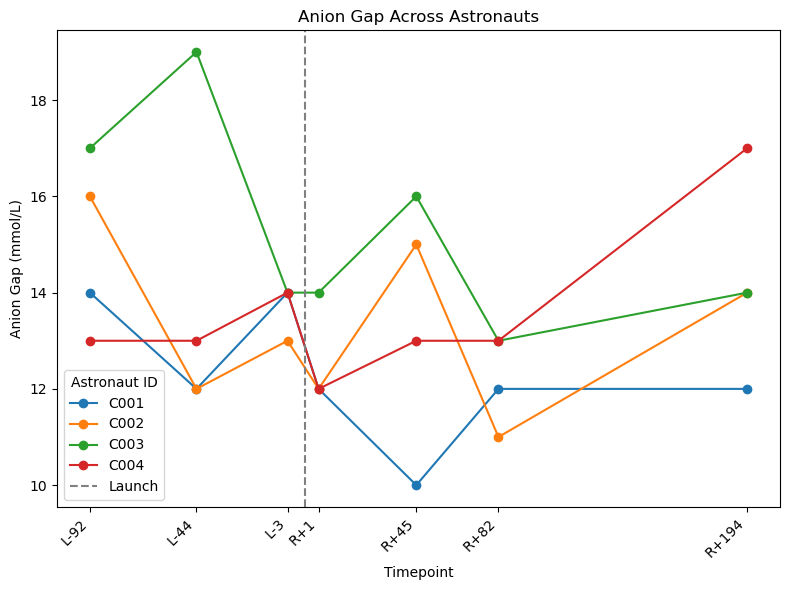

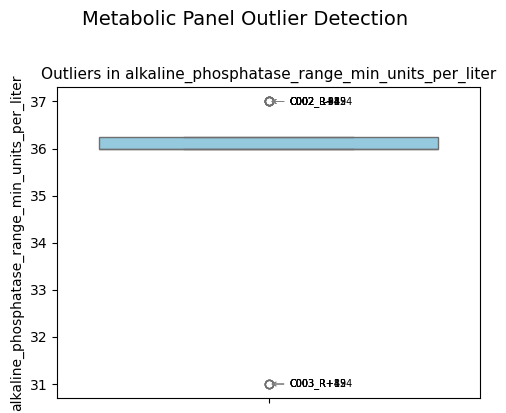

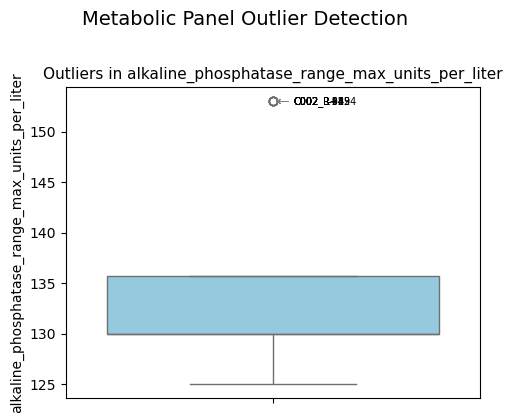

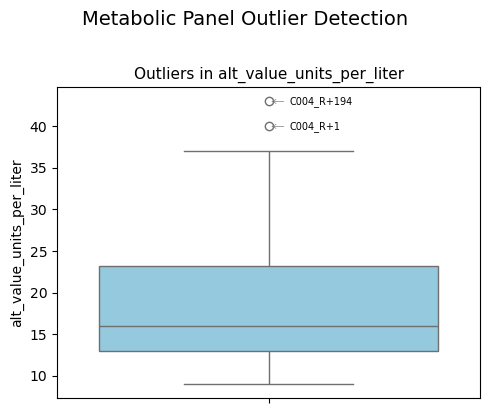

In [26]:
df = pd.read_csv("cleaned_data/LSDS-8_Comprehensive_Metabolic_Panel_CMP_TRANSFORMED_all_astronauts.csv")

df["anion_gap"] = df["sodium_value_millimol_per_liter"] - (
        df["chloride_value_millimol_per_liter"] + df["carbon_dioxide_value_millimol_per_liter"]
)
# plot Anion Gap over timepoints per astronaut
timepoint_mapping = {
    "L-92": -97,
    "L-44": -49,
    "L-3": -8,
    "R+1": 6,
    "R+45": 50,
    "R+82": 87,
    "R+194": 199
}

df["day"] = df["timepoint"].map(timepoint_mapping)

df_anion = df[["astronautID", "day", "timepoint", "anion_gap"]].dropna()
df_anion = df_anion.sort_values(by=["astronautID", "day"])

plt.figure(figsize=(8, 6))
for astro_id, sub_df in df_anion.groupby("astronautID"):
    plt.plot(sub_df["day"], sub_df["anion_gap"], marker="o", label=astro_id)

plt.title("Anion Gap Across Astronauts")
plt.xlabel("Timepoint")
plt.ylabel("Anion Gap (mmol/L)")
plt.axvline(0, color="gray", linestyle="--", label="Launch")
plt.xticks(
    ticks=list(timepoint_mapping.values()),
    labels=list(timepoint_mapping.keys()),
    rotation=45,
    ha="right"
)
plt.legend(title="Astronaut ID")
plt.tight_layout()
plt.show()

# Outlier detection across numeric columns
numeric_cols = df.select_dtypes(include=["number"]).columns

max_plots = 3  # Change to limit the number of plots shown
plotted = 0

for col in numeric_cols:
    if plotted >= max_plots:
        break

    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower) | (df[col] > upper)]

    if outliers.empty:
        continue  # skip this column if no outliers

    plt.figure(figsize=(5, 4))
    ax = sns.boxplot(y=df[col], color="skyblue")

    # Annotate outliers with astronaut ID and timepoint
    for idx, val in outliers[col].items():
        label = f"{df.loc[idx, 'astronautID']}_{df.loc[idx, 'timepoint']}"
        ax.annotate(
            label,
            xy=(0, val), xycoords="data",
            xytext=(15, 0), textcoords="offset points",
            ha="left", va="center", fontsize=7,
            arrowprops=dict(arrowstyle="->", lw=0.5, color="gray")
        )

    plt.title(f"Outliers in {col}", fontsize=11)
    plt.suptitle("Metabolic Panel Outlier Detection", fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

    plotted += 1

### Feature Engineering

Once we had our `final_data`, we applied the `featureEngineering.py` script to enrich the datasets with two key transformations:

1. Numeric flight-day scale
   - Raw `timepoint` labels like `L-3` and `R+1` are mapped onto a stretched numeric axis.
   - Launch day (`L0`) is set to day 0.
   - Pre-launch days count down into the negatives (e.g., `L-3 → -3`).
   - In-flight is artificially stretched to 30 days (`R+0 → 30`), so short spaceflights appear visibly distinct from recovery.
   - Recovery days then continue sequentially (`R+1 → 31`, `R+7 → 37`, etc.).
   - This stretching is intentional: while it introduces “fake” days, it ensures plots visually distinguish pre-launch**, in-flight, and post-flight phases.

2. Derived features
   - We compute the Anion Gap as:
     $$
     \text{Anion Gap} = [\text{Na}^+] - [\text{Cl}^-] - [\text{CO}_2]
     $$
   - This metric is clinically relevant for detecting metabolic acidosis and other imbalances, and is not directly provided in the raw data.
   - The function adds `anion_gap_value` along with placeholder `min`/`max` columns so the reference ranges can be defined in `stats.py`.

Together, these functions clean redundant columns (like `Sample Name`), provide a consistent timeline across astronauts, and introduce clinically meaningful derived biomarkers. This ensures downstream analysis and visualization are both aligned and interpretably enriched.

Additionally, we will use the `tidy_from_wide` function from `scripts/stats` which makes our data usable in future sections.


In [1]:
import pandas as pd
from scripts.featureEngineering import add_flight_day, add_derived_features
from scripts.stats import tidy_from_wide

# Load cleaned metabolic panel
df = pd.read_csv("final_data/Metabolic_Panel.csv")

# Feature engineering
df = add_flight_day(df)
df = add_derived_features(df)

# Convert to tidy format
tidy_df = tidy_from_wide(df)
tidy_df.head()

,astronautID,timepoint,flight_day,analyte,value,min,max,label,unit,sex
0,C001,L-3,-3,albumin,4.9,3.6,5.1,Albumin,g/dL,Male
1,C001,L-44,-44,albumin,5.0,3.6,5.1,Albumin,g/dL,Male
2,C001,L-92,-92,albumin,5.0,3.6,5.1,Albumin,g/dL,Male
3,C001,R+1,31,albumin,4.9,3.6,5.1,Albumin,g/dL,Male
4,C001,R+194,224,albumin,4.6,3.6,5.1,Albumin,g/dL,Male


### Identify All the Statistical Deviance

We want a simple table of analytes where an individual astronaut’s R+1 value was statistically different from baseline (p < 0.05), whether that difference is higher or lower than the baseline mean.

The code below takes the results from `analyze_r1_vs_L()` and filters for these conditions, then saves the table to CSV for easy inspection.

---

#### Statistical Background

For each astronaut $(a)$ and analyte $(x)$:

1. Baseline distribution
   Collect all pre-flight measurements (timepoints \(L-92, L-44, L-3\)):

   $$
   L_{a,x} = \{ v_{a,x}^{L-92}, v_{a,x}^{L-44}, v_{a,x}^{L-3} \}
   $$

   with sample mean

   $$
   \bar{L}_{a,x} = \frac{1}{n}\sum_{i=1}^{n} v_{a,x}^{L_i}
   $$

   and sample standard deviation

   $$
   s_{a,x} = \sqrt{\frac{1}{n-1}\sum_{i=1}^{n}(v_{a,x}^{L_i}-\bar{L}_{a,x})^2}.
   $$

2. R+1 observation
   Take the recovery-day measurement:

   $$
   R1_{a,x} = v_{a,x}^{R+1}.
   $$

3. One-sample t-test
   Null hypothesis $(H_0)$: astronaut’s R+1 value is consistent with baseline distribution.

   Test statistic:

   $$
   t = \frac{R1_{a,x} - \bar{L}_{a,x}}{s_{a,x}/\sqrt{n}}
   $$

   where $n = |L_{a,x}|$.
   The p-value is computed from Student’s $t$-distribution with $n-1$ degrees of freedom.

4. Effect size (Cohen’s d)
   To measure magnitude and direction:

   $$
   d = \frac{R1_{a,x} - \bar{L}_{a,x}}{s_{a,x}}
   $$

---

#### Why This Matters

- A significant p-value (< 0.05) means the R+1 value is unlikely to come from baseline variation.
- Positive Cohen’s d values indicate the R+1 measurement is higher than baseline.
- Negative Cohen’s d values indicate the R+1 measurement is lower than baseline.
- Considering both directions allows us to identify biomarkers that either spike (possible stress, inflammation, recovery) or drop (possible suppression, depletion, altered regulation).

In [2]:
from scripts.stats import analyze_r1_vs_L, ANALYTE_INFO

# Run analysis
results_df = analyze_r1_vs_L(tidy_df)

# Filter for significant deviations in either direction
elevated = results_df[
    (results_df["test_type"] == "within") &
    (results_df["p_value"] < 0.05) &
    (results_df["R1"] != results_df["mean_L"])
].copy()

# Add labels and units for readability
elevated["label"] = elevated["analyte"].map(lambda x: ANALYTE_INFO[x]["label"])
elevated["unit"] = elevated["analyte"].map(lambda x: ANALYTE_INFO[x]["unit"])

# Reorder columns
elevated = elevated[
    ["astronautID", "analyte", "label", "unit", "mean_L", "R1", "p_value", "effect_size"]
]

# Save to CSV
elevated.to_csv("R1_elevated_analytes.csv", index=False)

elevated.head()


,astronautID,analyte,label,unit,mean_L,R1,p_value,effect_size
8,C004,alkaline_phosphatase,Alkaline Phosphatase,U/L,56.33,62.0,0.0234,3.710
10,C001,alt,ALT,U/L,14.67,9.0,0.0234,-3.710
12,C003,alt,ALT,U/L,12.67,19.0,0.0028,10.970
13,C004,alt,ALT,U/L,36.33,40.0,0.0315,3.175
23,C004,calcium,Ca²⁺,mg/dL,10.10,9.8,0.0351,-3.000


### Visualizing Biomarkers Across Mission Days

We use an interactive plotting function (`make_figure`) to display biomarker trends over time.
This function builds a line plot for each astronaut, aligned to mission days, and overlays statistical reference bands when available. Healthy reference ranges are shown as dotted lines.
The plots can highlight individual or group-level deviations from baseline and mark statistically significant changes at R+1.

Below we call the function for sodium values across all astronauts.

In [3]:
from scripts.graphMaking import make_figure

fig = make_figure(
    tidy_df=tidy_df,
    stats_df=results_df,
    analytes=["sodium"],
    astronaut_filter=None,
    show_error="within"  # options: "within", "group", or None
)
fig.show()

## Putting it all together

As documented in `main.py` we can now run querries for whatever we want from the command line.

In [6]:
%run main.py

Available datasets:
  [0] Metabolic_Panel.csv
  [1] Serum_Cardiovascular.csv

Available analytes: albumin, alkaline_phosphatase, alt, ast, total_bilirubin, bun_to_creatinine_ratio, calcium, carbon_dioxide, chloride, creatinine, egfr_african_american, egfr_non_african_american, globulin, glucose, potassium, total_protein, sodium, urea_nitrogen_bun

Available astronauts: C001, C002, C003, C004
Options: 'All', 'Male', 'Female', or a comma-separated subset (e.g. C001,C002)

Loading final_data\Metabolic_Panel.csv ...
Generating figure for analytes: ['sodium']

Plotting sodium ...


## Run it as an App

Deployed Via `app.py` at the appropriate [Hugging Face Website](https://huggingface.co/spaces/DTanzillo/Inspiration-Health-Data).